In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
calendar_path = os.path.join(os.getcwd(), 'data', 'calendar.csv')
trainDF_path = os.path.join(os.getcwd(), 'data', 'sales_train_validation.csv')
pricesDF_path = os.path.join(os.getcwd(), 'data', 'sell_prices.csv')

df = pd.read_csv(trainDF_path)
calendarDF = pd.read_csv(calendar_path)
# pricesDF = pd.read_csv(pricesDF_path)

In [3]:

# renaming d_### format to actual dates
df = df.rename(columns=dict(zip(calendarDF.d.tolist(), pd.to_datetime(calendarDF.date).tolist())))



In [4]:
testCutOff = 30 #days removed for test set

dateStart = 1180 #pick something between 1 and 1913-testCutOff

prodIndex = 2435

dfNoLabels = df.iloc[:,6+dateStart:]

# train, test = npNorm[prodIndex,:npNorm.shape[1]-testCutOff], npNorm[prodIndex,npNorm.shape[1]-testCutOff:]
train = dfNoLabels.iloc[prodIndex,:-testCutOff]
test = dfNoLabels.iloc[prodIndex,-testCutOff:]

train.index = pd.to_datetime(dfNoLabels.iloc[prodIndex,:-testCutOff].index)
test.index = pd.to_datetime(dfNoLabels.iloc[prodIndex,-testCutOff:].index)

In [5]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [6]:
best = find_best_sarima(train, 'aic')


In [7]:
best

{'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2773e61f240>,
 'aic': 2507.3346510367155,
 'bic': 2529.9230074012767,
 'order': (1, 0, 1),
 'seasonal_order': (1, 1, 1, 12)}

In [8]:
# pred = best['model'].predict(start=0, end=test.shape[0]-1, dynamic=True)

pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)



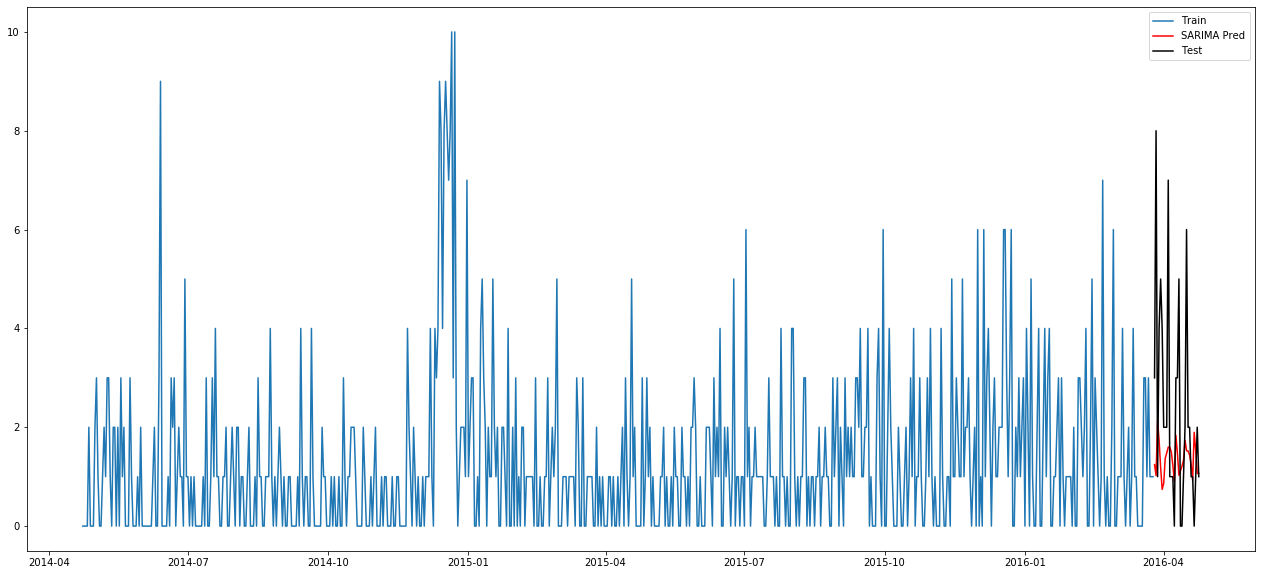

In [9]:

plt.figure(figsize=(22, 10))

plt.plot(train.index, train, label='Train')
plt.plot(pred.index, pred, label='SARIMA Pred', color='r')
plt.plot(test.index, test, label='Test', color='k')

plt.legend(loc='best')
plt.show()

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, 
                                                          param_seasonal, 
                                                          results.aic, 
                                                          results.bic))

        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3008.3957464325817 - BIC:3012.9496798366076
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2890.7875241263264 - BIC:2899.860907321509
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3082.15090740214 - BIC:3086.6875989997316
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2616.5169696567223 - BIC:2625.555264232603
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2845.6574829523397 - BIC:2854.7337625998753
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2660.696113554658 - BIC:2674.306188347432
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2841.0184204724865 - BIC:2850.059662727604
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2618.5169749510687 - BIC:2632.07441681489
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2851.710656515835 - BIC:2860.8156722899043
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2783.142246895214 - BIC:2796.7479707082553
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3061.118544334009 - BIC:3070.189026876036
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2575.5928161159736 - BIC:2589.1458299347105
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2772